Hey fellas,

Welcome to second asignment series. Here we are gonna use Backprop to correct errors. The first task is to go through this complete code and understand its working.  Then go at the end of code and see the XOR implementation. Something is missing over there. Try to rectify the code( either augment the given code or write your own). Also mention what was missing  though in a text box. I would appreciate if you guys share the google colab notebook link directly to amritansh.48@gmail.com.

In [1]:
import random
import math

In [2]:
class NeuralNetwork:
    LEARNING_RATE = 0.05

    def update_learning_rate(self, new_rate):
      self.LEARNING_RATE = new_rate


    def __init__(self, num_inputs, num_hidden, num_outputs, hidden_layer_weights = None, hidden_layer_bias = None, output_layer_weights = None, output_layer_bias = None):
        self.num_inputs = num_inputs

        self.hidden_layer = NeuronLayer(num_hidden, hidden_layer_bias)
        self.output_layer = NeuronLayer(num_outputs, output_layer_bias)

        self.init_weights_from_inputs_to_hidden_layer_neurons(hidden_layer_weights)
        self.init_weights_from_hidden_layer_neurons_to_output_layer_neurons(output_layer_weights)

    def init_weights_from_inputs_to_hidden_layer_neurons(self, hidden_layer_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_weights:
                    self.hidden_layer.neurons[h].weights.append(random.random())
                else:
                    self.hidden_layer.neurons[h].weights.append(hidden_layer_weights[weight_num])
                weight_num += 1

    def init_weights_from_hidden_layer_neurons_to_output_layer_neurons(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(random.random())
                else:
                    self.output_layer.neurons[o].weights.append(output_layer_weights[weight_num])
                weight_num += 1
                
    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer')
        self.hidden_layer.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')

    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs)
        return self.output_layer.feed_forward(hidden_layer_outputs)
      
    
    # Uses online learning, ie updating the weights after each training case
    def train(self, training_inputs, training_outputs):
        self.feed_forward(training_inputs)

        # 1. Output neuron deltas
        pd_errors_wrt_output_neuron_total_net_input = [0] * len(self.output_layer.neurons)
        for o in range(len(self.output_layer.neurons)):

            # ∂E/∂zⱼ
            pd_errors_wrt_output_neuron_total_net_input[o] = self.output_layer.neurons[o].calculate_pd_error_wrt_total_net_input(training_outputs[o])

        # 2. Hidden neuron deltas
        pd_errors_wrt_hidden_neuron_total_net_input = [0] * len(self.hidden_layer.neurons)
        for h in range(len(self.hidden_layer.neurons)):

            # We need to calculate the derivative of the error with respect to the output of each hidden layer neuron
            # dE/dyⱼ = Σ ∂E/∂zⱼ * ∂z/∂yⱼ = Σ ∂E/∂zⱼ * wᵢⱼ
            d_error_wrt_hidden_neuron_output = 0
            for o in range(len(self.output_layer.neurons)):
                d_error_wrt_hidden_neuron_output += pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].weights[h]

            # ∂E/∂zⱼ = dE/dyⱼ * ∂zⱼ/∂
            pd_errors_wrt_hidden_neuron_total_net_input[h] = d_error_wrt_hidden_neuron_output * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_input()

        # 3. Update output neuron weights
        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):

                # ∂Eⱼ/∂wᵢⱼ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢⱼ
                pd_error_wrt_weight = pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].calculate_pd_total_net_input_wrt_weight(w_ho)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.output_layer.neurons[o].weights[w_ho] -= self.LEARNING_RATE * pd_error_wrt_weight

        # 4. Update hidden neuron weights
        for h in range(len(self.hidden_layer.neurons)):
            for w_ih in range(len(self.hidden_layer.neurons[h].weights)):

                # ∂Eⱼ/∂wᵢ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢ
                pd_error_wrt_weight = pd_errors_wrt_hidden_neuron_total_net_input[h] * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_weight(w_ih)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.hidden_layer.neurons[h].weights[w_ih] -= self.LEARNING_RATE * pd_error_wrt_weight
                
                
    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].calculate_error(training_outputs[o])
        return total_error



In [3]:
class NeuronLayer:
    def __init__(self, num_neurons, bias):

        # Every neuron in a layer shares the same bias
        self.bias = bias if bias else random.random()

        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

In [4]:
class Neuron:
    def __init__(self, bias):
        self.bias = bias
        self.weights = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    # Apply the logistic function to squash the output of the neuron

    def squash(self, total_net_input):
        return 1 / (1 + math.exp(-total_net_input))

    # Determine how much the neuron's total input has to change to move closer to the expected output
    #
    # Now that we have the partial derivative of the error with respect to the output (∂E/∂yⱼ) and
    # the derivative of the output with respect to the total net input (dyⱼ/dzⱼ) we can calculate
    # the partial derivative of the error with respect to the total net input.
    # This value is also known as the delta (δ) [1]
    # δ = ∂E/∂zⱼ = ∂E/∂yⱼ * dyⱼ/dzⱼ
    #
    # Manoj : ∂E/∂yⱼ -> Correspond the derivatives of output layer, But ∂yⱼ itself is dependent on output from hidden layer, i.e ∂yⱼ/∂zⱼ
    #       : So, ∂E/∂zⱼ = ∂E/∂yⱼ * dyⱼ/dzⱼ  (here it is not partial detivatives because there is only one variable)

    def calculate_pd_error_wrt_total_net_input(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.calculate_pd_total_net_input_wrt_input();

    # The error for each neuron is calculated by the Mean Square Error method:
    # Manoj: Just MSE calculation
    def calculate_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    # The partial derivate of the error with respect to actual output then is calculated by:
    # = 2 * 0.5 * (target output - actual output) ^ (2 - 1) * -1
    # = -(target output - actual output)
    #
    # The Wikipedia article on backpropagation [1] simplifies to the following, but most other learning material does not [2]
    # = actual output - target output
    #
    # Alternative, you can use (target - output), but then need to add it during backpropagation [3]
    #
    # Note that the actual output of the output neuron is often written as yⱼ and target output as tⱼ so:
    # = ∂E/∂yⱼ = -(tⱼ - yⱼ)
    def calculate_pd_error_wrt_output(self, target_output):
        return -(target_output - self.output)

    # The total net input into the neuron is squashed using logistic function to calculate the neuron's output:
    # yⱼ = φ = 1 / (1 + e^(-zⱼ))
    # Note that where ⱼ represents the output of the neurons in whatever layer we're looking at and ᵢ represents the layer below it
    #
    # The derivative (not partial derivative since there is only one variable) of the output then is:
    # dyⱼ/dzⱼ = yⱼ * (1 - yⱼ)
    def calculate_pd_total_net_input_wrt_input(self):
        return self.output * (1 - self.output)

    # The total net input is the weighted sum of all the inputs to the neuron and their respective weights:
    # = zⱼ = netⱼ = x₁w₁ + x₂w₂ ...
    #
    # The partial derivative of the total net input with respective to a given weight (with everything else held constant) then is:
    # = ∂zⱼ/∂wᵢ = some constant + 1 * xᵢw₁^(1-0) + some constant ... = xᵢ
    def calculate_pd_total_net_input_wrt_weight(self, index):
        return self.inputs[index]


In [5]:
# Example 1

nn = NeuralNetwork(2, 2, 2, hidden_layer_weights=[0.15, 0.2, 0.25, 0.3], hidden_layer_bias=0.35, output_layer_weights=[0.4, 0.45, 0.5, 0.55], output_layer_bias=0.6)
for i in range(100):
    nn.train([0.05, 0.1], [0.01, 0.99])
    print(i, round(nn.calculate_total_error([[[0.05, 0.1], [0.01, 0.99]]]), 9))


0 0.297639963
1 0.29690735
2 0.296173281
3 0.295437769
4 0.294700824
5 0.29396246
6 0.293222689
7 0.292481524
8 0.291738978
9 0.290995064
10 0.290249795
11 0.289503187
12 0.288755252
13 0.288006005
14 0.287255461
15 0.286503634
16 0.285750539
17 0.284996193
18 0.284240609
19 0.283483804
20 0.282725795
21 0.281966596
22 0.281206226
23 0.2804447
24 0.279682035
25 0.278918249
26 0.27815336
27 0.277387384
28 0.27662034
29 0.275852246
30 0.275083121
31 0.274312982
32 0.273541849
33 0.272769742
34 0.271996678
35 0.271222678
36 0.270447761
37 0.269671948
38 0.268895259
39 0.268117713
40 0.267339332
41 0.266560137
42 0.265780148
43 0.264999386
44 0.264217873
45 0.263435631
46 0.262652682
47 0.261869047
48 0.261084749
49 0.260299809
50 0.259514251
51 0.258728098
52 0.257941372
53 0.257154096
54 0.256366294
55 0.255577988
56 0.254789204
57 0.253999964
58 0.253210292
59 0.252420212
60 0.251629749
61 0.250838927
62 0.25004777
63 0.249256303
64 0.248464551
65 0.247672538
66 0.246880291
67 0.2460878

In [6]:
# XOR example - Homework. Correct the implemnation to run XOR problem with higher accuracy, Mention and add whats missing:

training_sets = [
    [[0, 0], [0]],
    [[0, 1], [1]],
    [[1, 0], [1]],
    [[1, 1], [0]]
]

nn = NeuralNetwork(len(training_sets[0][0]), 5, len(training_sets[0][1]))
for i in range(100):
    training_inputs, training_outputs = random.choice(training_sets)
    nn.train(training_inputs, training_outputs)
    print(i, nn.calculate_total_error(training_sets))

0 0.7616419595268031
1 0.7597514803513958
2 0.7600370876688824
3 0.7581266236571529
4 0.7584177255569531
5 0.758707822663123
6 0.7567808315401212
7 0.7570809271107328
8 0.7573799781379917
9 0.7554365082250891
10 0.7557412039251676
11 0.7560405103608132
12 0.7563431173969435
13 0.754386793519018
14 0.7546951136224933
15 0.75271843640833
16 0.7510338299925383
17 0.7513539378578107
18 0.7516728918648954
19 0.7496591508776846
20 0.7499841289530216
21 0.7503038000545088
22 0.7482732855773795
23 0.7486032455274172
24 0.7489278931011272
25 0.7492554898532757
26 0.7495777797438963
27 0.7478687467060213
28 0.7482001731088196
29 0.7464802551782495
30 0.7468126667704665
31 0.7450818504283525
32 0.7433375818133563
33 0.7415798601573906
34 0.7394441974831569
35 0.7372830477456178
36 0.7350962757441234
37 0.732883760693154
38 0.7306453973087932
39 0.7310423220944762
40 0.7314376468967467
41 0.7295933046315812
42 0.729990834390809
43 0.7281360342406407
44 0.7258430413386096
45 0.7262592899263254
46 0

In [7]:
len(training_sets[0][1])

1

In [8]:
# XOR example - Homework. Correct the implemnation to run XOR problem with higher accuracy, Mention and add whats missing:
# Mycode -->
#  1) Added update_learning_rate method in NeuralNetwork class to update learning rate
#  2) Incrased iteration from 100 to 10000
#  3) Implemented custom tuning parameter for learning rate.
#      - selected range of learning rate and calculated the error
#      - selected best learning rate


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

neuraons_in_hidden_layer = 5
neuraons_in_output_layer = 2
num_of_iteration = 1000

training_sets = [
    [[0, 0], [0.3, 0.7]],
    [[0, 1], [0.8, 0.2]],
    [[1, 0], [0.85, 0.15]],
    [[1, 1], [0.8, 0.2]]
]

df = pd.DataFrame()
#nn.update_learning_rate(0.5)

for new_learn_rate in np.linspace(0.01, 2, 50):
  error_collection = []
  nn = NeuralNetwork(len(training_sets[0][0]), neuraons_in_hidden_layer, neuraons_in_output_layer)
  nn.update_learning_rate(new_learn_rate)
  for i in range(num_of_iteration):
      training_inputs, training_outputs = random.choice(training_sets)
      nn.train(training_inputs, training_outputs)  
      error_collection.append(nn.calculate_total_error(training_sets)) 
      #print(i, nn.calculate_total_error(training_sets))
    
  df[new_learn_rate] = error_collection

In [9]:
df.head()

,0.010000,0.050612,0.091224,0.131837,0.172449,0.213061,0.253673,0.294286,0.334898,0.375510,0.416122,0.456735,0.497347,0.537959,0.578571,0.619184,0.659796,0.700408,0.741020,0.781633,0.822245,0.862857,0.903469,0.944082,0.984694,1.025306,1.065918,1.106531,1.147143,1.187755,1.228367,1.268980,1.309592,1.350204,1.390816,1.431429,1.472041,1.512653,1.553265,1.593878,1.634490,1.675102,1.715714,1.756327,1.796939,1.837551,1.878163,1.918776,1.959388,2.000000
0,0.772554,0.855904,0.888735,0.792275,0.841142,0.683518,0.854609,0.636970,0.685199,0.701746,0.900459,0.766263,0.689768,0.595941,0.802014,0.789716,0.780773,0.829953,0.670714,0.643058,0.671344,0.809685,0.698257,0.946623,0.744460,0.841756,0.714845,0.712398,0.844368,0.754122,0.588799,0.841369,0.867153,0.821664,0.768280,0.760864,0.733730,0.795665,0.807636,0.904072,0.876542,0.841389,0.903779,0.787542,0.802525,0.773203,0.841131,0.818678,0.770259,0.865734
1,0.772610,0.854656,0.887629,0.788496,0.841524,0.686357,0.854979,0.643599,0.690982,0.707555,0.900740,0.741833,0.695518,0.561748,0.787411,0.765774,0.758918,0.815488,0.680559,0.660037,0.683120,0.778166,0.706311,0.946720,0.754092,0.822592,0.723638,0.727361,0.846535,0.681508,0.620523,0.802140,0.844521,0.826552,0.690780,0.770257,0.748597,0.803848,0.812395,0.905013,0.860935,0.797267,0.886684,0.737550,0.810276,0.704039,0.845336,0.824168,0.783468,0.831648
2,0.772666,0.854763,0.886390,0.789042,0.837715,0.674858,0.849826,0.621157,0.696502,0.712588,0.895784,0.746340,0.671304,0.527085,0.789637,0.769821,0.733569,0.798620,0.648035,0.675567,0.693874,0.783586,0.671341,0.942963,0.698675,0.825565,0.677795,0.741989,0.848723,0.589194,0.543272,0.749091,0.846985,0.776760,0.713054,0.710954,0.671236,0.811548,0.816820,0.905926,0.836685,0.730101,0.887645,0.674571,0.817148,0.617225,0.849220,0.829172,0.690262,0.775243
3,0.772717,0.854871,0.885128,0.789511,0.833732,0.663115,0.844549,0.628523,0.671848,0.687246,0.896108,0.750624,0.677893,0.544574,0.791693,0.742064,0.704412,0.800913,0.614542,0.624986,0.648204,0.788125,0.681634,0.943044,0.627875,0.828398,0.636358,0.753017,0.850818,0.522222,0.507258,0.761119,0.849332,0.786158,0.613317,0.726830,0.696065,0.818000,0.776486,0.906813,0.805604,0.628772,0.865345,0.695042,0.751464,0.655499,0.852674,0.833759,0.721336,0.692678
4,0.772345,0.853621,0.885209,0.790049,0.834123,0.649440,0.845003,0.635503,0.648835,0.662256,0.896428,0.754704,0.684170,0.562604,0.793692,0.709175,0.710872,0.803284,0.572580,0.574657,0.661645,0.753192,0.644956,0.940004,0.653889,0.805959,0.594307,0.685560,0.827171,0.506294,0.538874,0.771249,0.851328,0.719657,0.653661,0.656336,0.717182,0.823820,0.723926,0.889030,0.765628,0.542946,0.867341,0.610061,0.650409,0.566688,0.855896,0.837962,0.603572,0.720015


In [10]:
df.tail()

,0.010000,0.050612,0.091224,0.131837,0.172449,0.213061,0.253673,0.294286,0.334898,0.375510,0.416122,0.456735,0.497347,0.537959,0.578571,0.619184,0.659796,0.700408,0.741020,0.781633,0.822245,0.862857,0.903469,0.944082,0.984694,1.025306,1.065918,1.106531,1.147143,1.187755,1.228367,1.268980,1.309592,1.350204,1.390816,1.431429,1.472041,1.512653,1.553265,1.593878,1.634490,1.675102,1.715714,1.756327,1.796939,1.837551,1.878163,1.918776,1.959388,2.000000
995,0.581625,0.504612,0.511405,0.514895,0.507866,0.521274,0.512891,0.499592,0.540161,0.521412,0.500352,0.476568,0.500167,0.493193,0.514058,0.499252,0.509203,0.524720,0.510066,0.579833,0.557991,0.496499,0.500471,0.522808,0.519487,0.504895,0.517995,0.559262,0.503423,0.516180,0.460743,0.451445,0.514945,0.618366,0.584969,0.525135,0.387278,0.388360,0.489732,0.246240,0.491488,0.546227,0.646565,0.495114,0.509881,0.529889,0.281576,0.610452,0.203161,0.456817
996,0.581873,0.504940,0.513139,0.517260,0.510636,0.526039,0.507767,0.499152,0.524721,0.507682,0.509144,0.466308,0.500598,0.507267,0.523331,0.497025,0.502380,0.509022,0.521500,0.600359,0.530663,0.494611,0.489484,0.500743,0.544289,0.514952,0.505630,0.500016,0.512646,0.490185,0.466758,0.463974,0.501004,0.556176,0.511829,0.542819,0.397676,0.369371,0.496403,0.257506,0.490348,0.510836,0.668806,0.496014,0.544900,0.549666,0.265296,0.553463,0.219566,0.469603
997,0.581192,0.505343,0.514984,0.514263,0.514261,0.517359,0.512288,0.501079,0.535354,0.500928,0.499811,0.464900,0.500223,0.491477,0.532844,0.502305,0.508419,0.501129,0.509151,0.619160,0.546068,0.514277,0.494724,0.513521,0.578795,0.502850,0.514567,0.528682,0.502234,0.506228,0.481722,0.517776,0.501925,0.505345,0.561825,0.513556,0.408198,0.364205,0.489402,0.278759,0.491812,0.533007,0.687957,0.502695,0.399964,0.518782,0.267655,0.515677,0.246132,0.497535
998,0.580512,0.504882,0.512360,0.511614,0.518249,0.510299,0.517256,0.499012,0.520926,0.500652,0.506525,0.464720,0.502474,0.484503,0.516863,0.514872,0.517082,0.498917,0.500500,0.635931,0.520685,0.531188,0.488415,0.498717,0.600434,0.500805,0.526083,0.491229,0.509184,0.489300,0.460479,0.462913,0.510795,0.497549,0.604171,0.536526,0.380519,0.375027,0.490550,0.300483,0.489488,0.507268,0.628255,0.495751,0.329612,0.502276,0.265460,0.501821,0.179591,0.514312
999,0.580762,0.504566,0.510413,0.513765,0.522095,0.506034,0.509825,0.501160,0.510270,0.500670,0.498744,0.464758,0.506995,0.491970,0.506078,0.531289,0.527269,0.500823,0.506503,0.651505,0.535102,0.563107,0.491059,0.505760,0.619976,0.505992,0.536821,0.501408,0.502657,0.500666,0.482023,0.449588,0.500916,0.514900,0.522869,0.509189,0.419878,0.364892,0.488770,0.318444,0.492733,0.501661,0.570105,0.502508,0.355653,0.512460,0.264770,0.519774,0.160753,0.466807


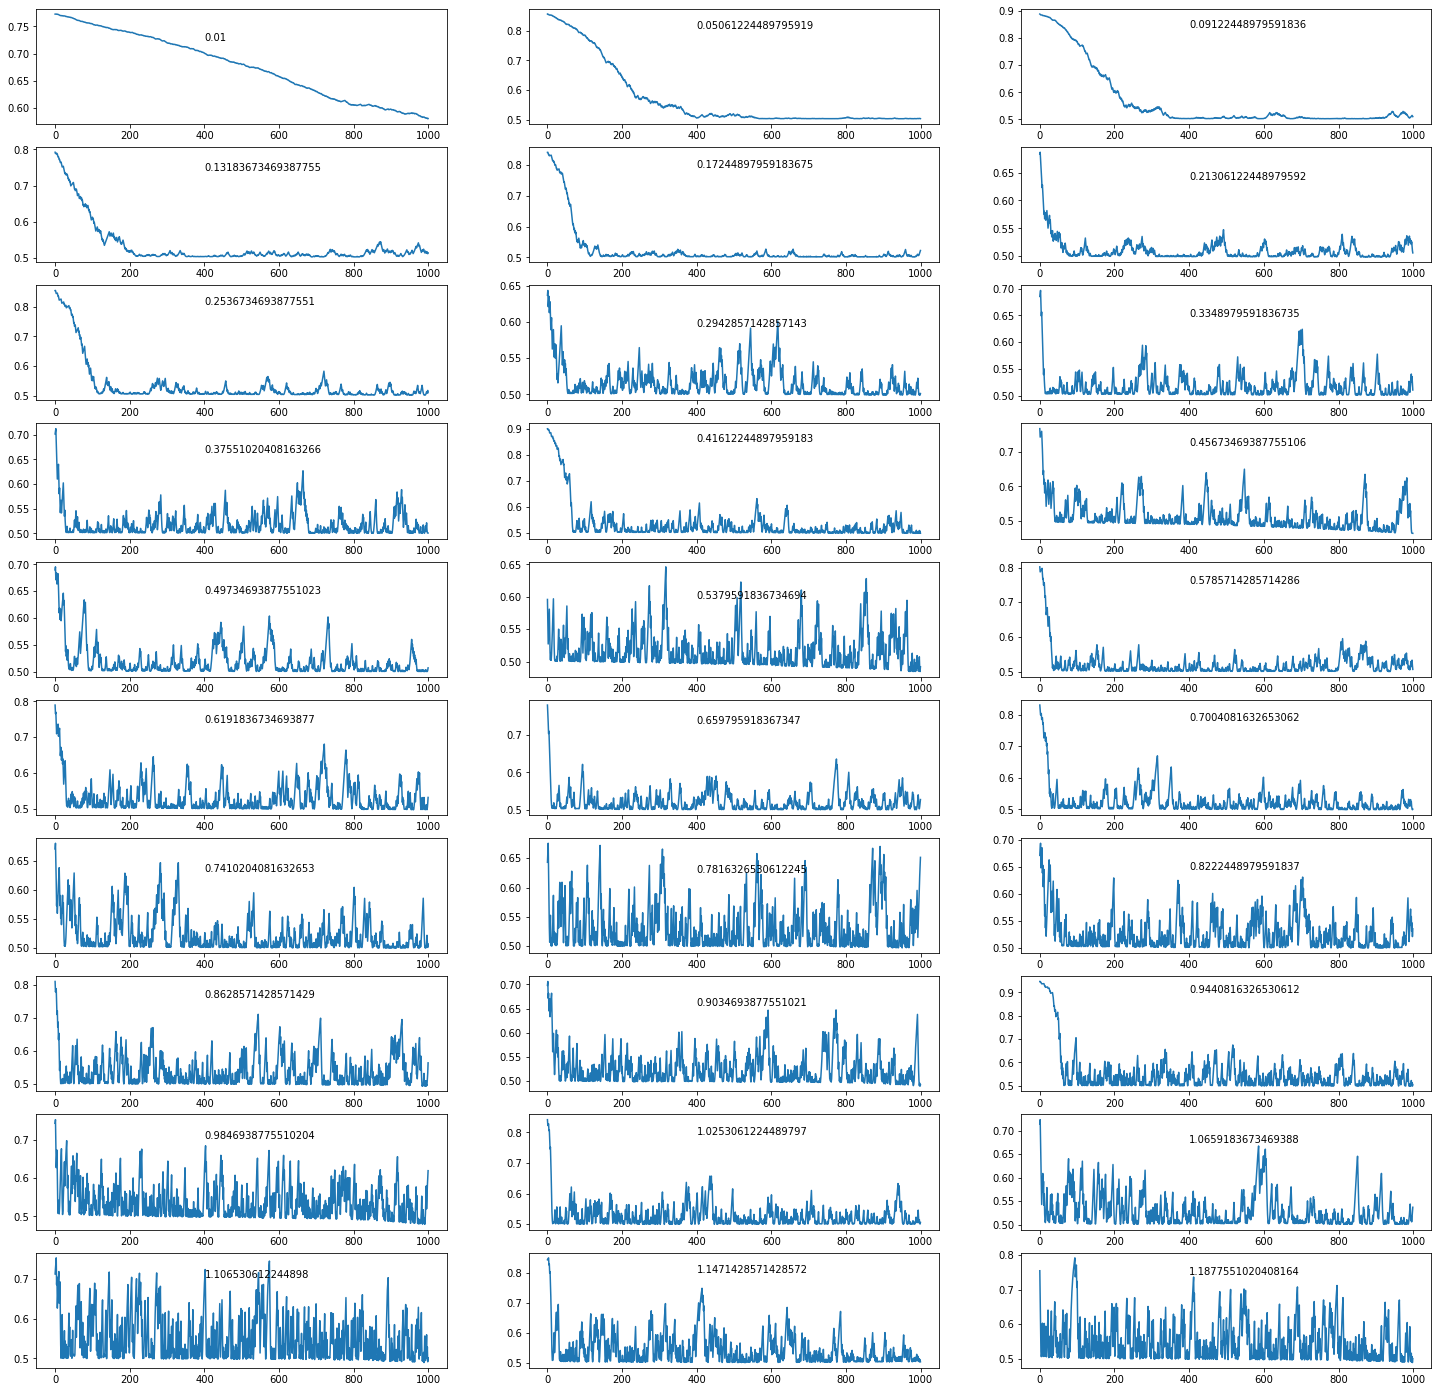

In [11]:
row = 10
col = 3
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(25, 25))
df_columns = 0
for row_i in range(0, row):
  for col_i in range(0, col):
    ax[row_i][col_i].plot(df.iloc[:,df_columns])
    ax[row_i][col_i].text(x=400, y=(max(np.array(df.iloc[:,df_columns]))-0.05), s=f"{df.columns[df_columns]}")
    df_columns += 1


In [13]:
# Based on the above exploration learning 1.878 is chossen because it has least covergence value
training_sets = [
    [[0, 0], [0]],
    [[0, 1], [1]],
    [[1, 0], [1]],
    [[1, 1], [0]]
]

nn = NeuralNetwork(len(training_sets[0][0]), neuraons_in_hidden_layer, neuraons_in_output_layer)
nn.update_learning_rate(1.959)
for i in range(num_of_iteration):
    training_inputs, training_outputs = random.choice(training_sets)
    nn.train(training_inputs, training_outputs)
    print(i, nn.calculate_total_error(training_sets))

0 0.7296226386442588
1 0.6274109602370795
2 0.5128580585584261
3 0.5188556797903592
4 0.5929518185084988
5 0.504584369768303
6 0.5359652135973172
7 0.5044995956686819
8 0.5343610209542992
9 0.5970830120392805
10 0.6552538772030762
11 0.6896415675647368
12 0.7159527560765231
13 0.5960387330524313
14 0.5106522230669385
15 0.5702998513290229
16 0.625708324478571
17 0.666920325982074
18 0.7036137211241019
19 0.7265794174606097
20 0.745087219788162
21 0.7627534602261732
22 0.7771255060426797
23 0.7877005236990412
24 0.7969206244378368
25 0.8050485477331266
26 0.8131569832957029
27 0.7451756113327213
28 0.647801229587314
29 0.5418327927564764
30 0.6025507828692582
31 0.6493464572526948
32 0.684144797073067
33 0.7108100733956907
34 0.6044631843754564
35 0.5136890923031416
36 0.5304071161738042
37 0.6027277204626186
38 0.5058435552694414
39 0.53747406030731
40 0.6119512998762837
41 0.5176112929116454
42 0.5105353771670892
43 0.5209813224552244
44 0.5825890119040824
45 0.633935778835022
46 0.51

In [14]:
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()